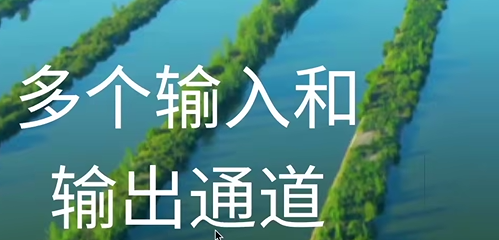

通道数 也是一种超参数 是比较常设置的参数

彩色图片通常有RGB三个通道 之前用的黑白图片即只有一个通道
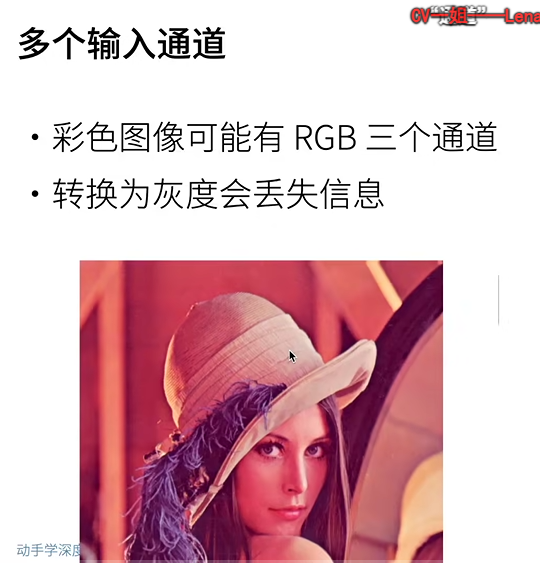

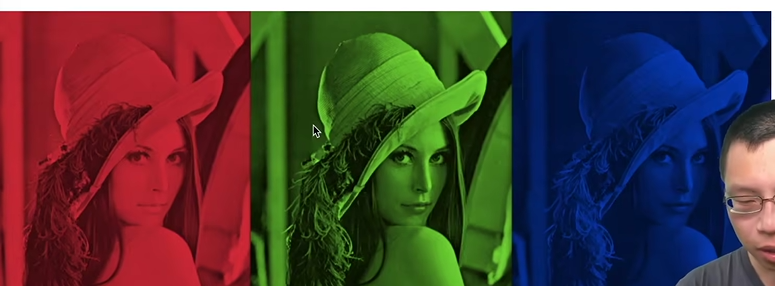

每一个通道都要有一个对应的卷积核

此例子是两个通道 分别是对应的第一个通道矩阵乘法对应的核 再加上第二个通道矩阵乘法对应的核

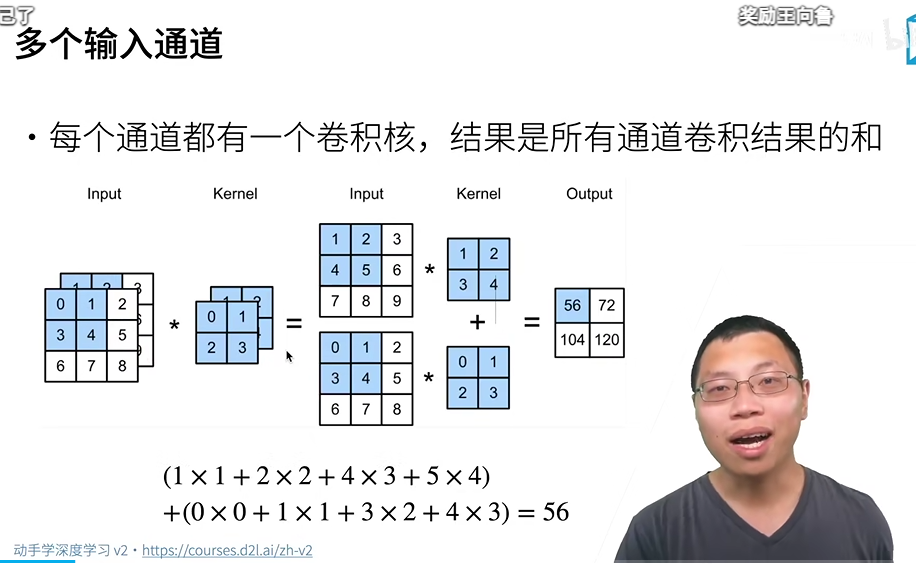


每一个通道与对应的卷积做矩阵乘法 在对应相加
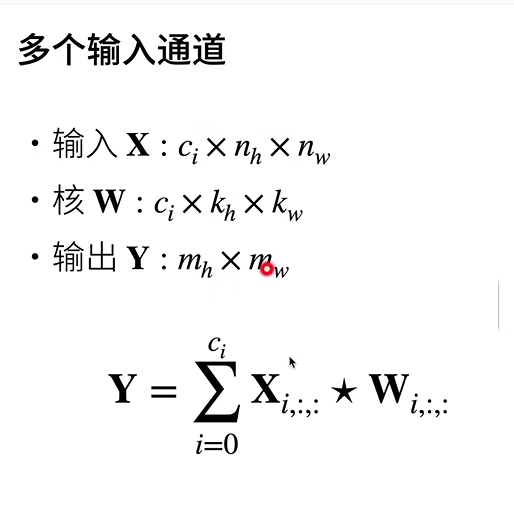

之前只能得到单输出通道

在最流行的神经网络架构中，随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。直观地说，我们可以将每个通道看作对不同特征的响应。而现实可能更为复杂一些，因为每个通道不是独立学习的，而是为了共同使用而优化的。因此，多输出通道并不仅是学习多个单通道的检测器。

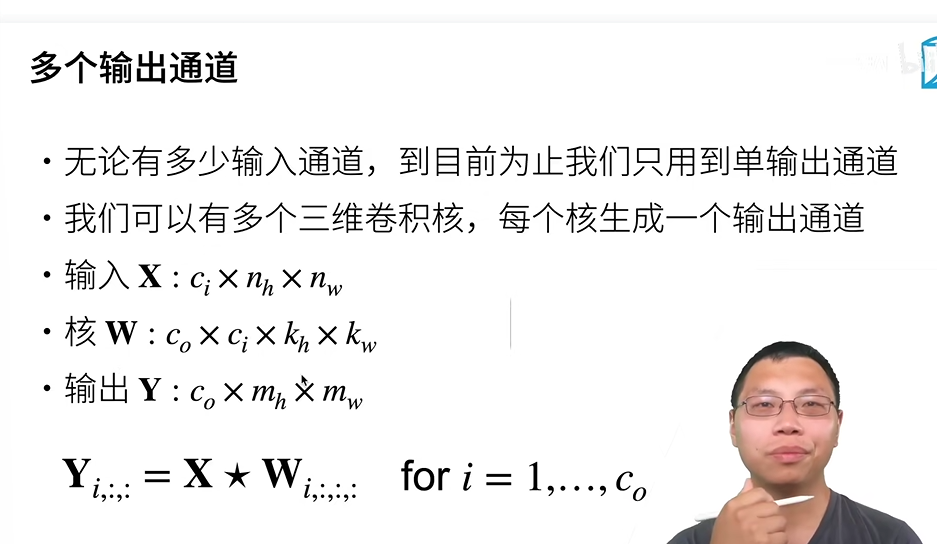

为什么要有多个输入和输出通道

在最流行的神经网络架构中，随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。直观地说，我们可以将每个通道看作对不同特征的响应。而现实可能更为复杂一些，因为每个通道不是独立学习的，而是为了共同使用而优化的。因此，多输出通道并不仅是学习多个单通道的检测器

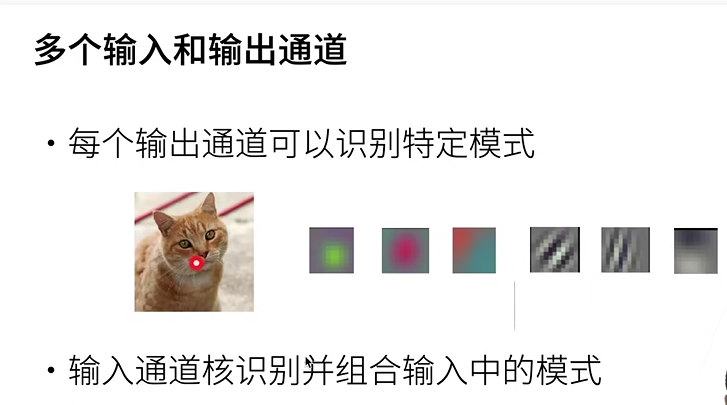




一种特殊的卷积核 1x1卷积核 是一种特殊情况的卷积层 也可以看作一个全连接层

下面具有三通道的3x3输入  卷积核是两个通道的1x1卷积核  输出得到两个通道的3x3

当以每像素为基础应用时，1x1卷积层相当于全连接层。

1x1卷积层通常用于调整网络层的通道数量和控制模型复杂性。


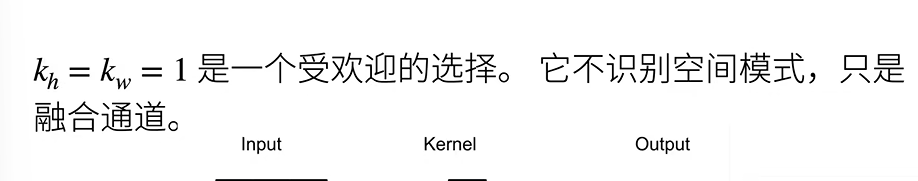

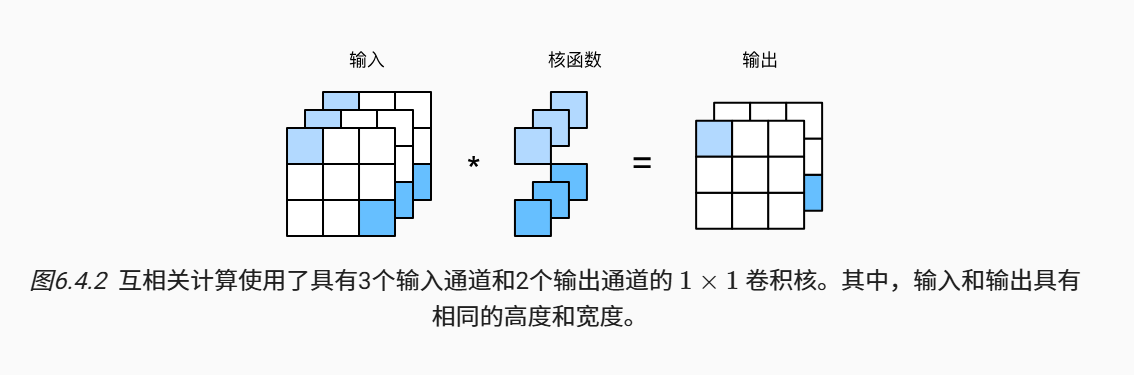

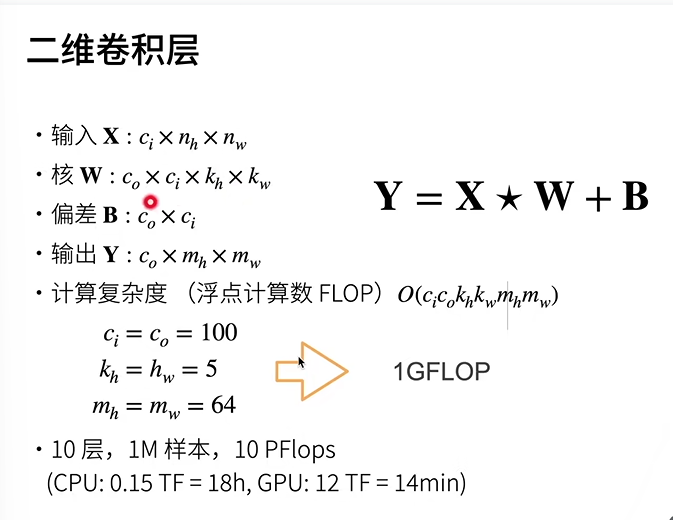

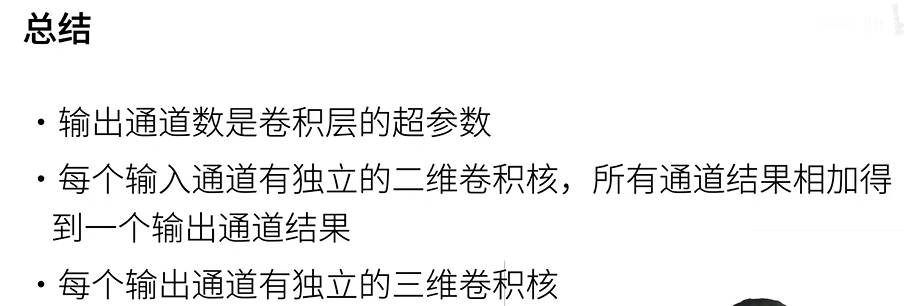

In [6]:
#实现一下多输入通道 的互相关运算
import torch
from d2l import torch as d2l


#输入X和K
def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

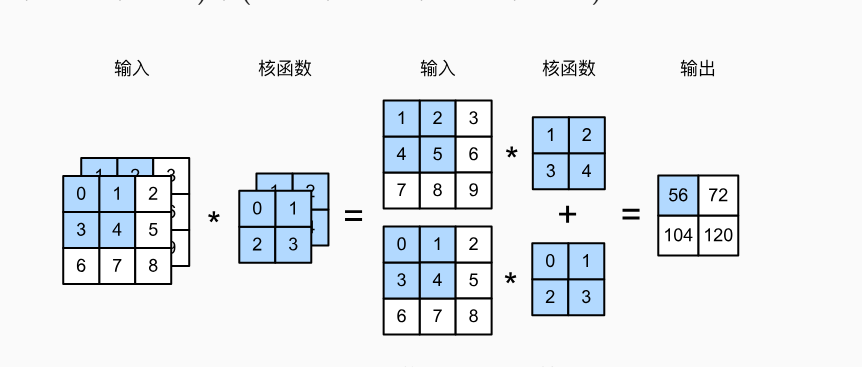

In [7]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])


K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [8]:
X,K

(tensor([[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]],
 
         [[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]),
 tensor([[[0., 1.],
          [2., 3.]],
 
         [[1., 2.],
          [3., 4.]]]))

# 计算多个通道的输出的互相关函数

In [9]:
# 函数的意义：使用stack可以保留两个信息：[1. 序列] 和 [2. 张量矩阵] 信息，属于【扩张再拼接】的函数。

# 形象的理解：假如数据都是二维矩阵(平面)，它可以把这些一个个平面按第三维(例如：时间序列)压成一个三维的立方体，而立方体的长度就是时间序列长度。
# 该函数常出现在自然语言处理（NLP）和图像卷积神经网络(CV)中。
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [13]:
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])
K

tensor([[[0., 1.],
         [2., 3.]],

        [[1., 2.],
         [3., 4.]]])

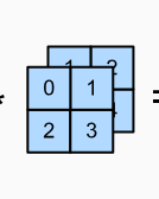

In [14]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [15]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [16]:
def corr2d_multi_in_out_1x1(X, K):
    # 获取输入张量的通道数、高度和宽度
    c_i, h, w = X.shape
    # 获取卷积核的输出通道数
    c_o = K.shape[0]
    # 将输入张量调整形状为 (c_i, h * w)，展平空间维度
    X = X.reshape((c_i, h * w))
    # 将卷积核调整形状为 (c_o, c_i)
    K = K.reshape((c_o, c_i))
    # 进行矩阵乘法，相当于全连接层操作
    Y = torch.matmul(K, X)
    # 将结果重塑回 (c_o, h, w) 形状，恢复空间维度
    return Y.reshape((c_o, h, w))

In [21]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

Y1==Y2

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]]])

In [22]:
Y1,Y2

(tensor([[[ 4.5554,  2.4410,  1.6146],
          [ 0.5229,  4.3072,  0.1982],
          [-0.3814, -0.5586, -2.0443]],
 
         [[-0.4112,  1.1559, -1.8533],
          [-1.8096, -2.1718,  0.5103],
          [ 1.5857, -1.2347,  0.8058]]]),
 tensor([[[ 4.5554,  2.4410,  1.6146],
          [ 0.5229,  4.3072,  0.1982],
          [-0.3814, -0.5586, -2.0443]],
 
         [[-0.4112,  1.1559, -1.8533],
          [-1.8096, -2.1718,  0.5103],
          [ 1.5857, -1.2347,  0.8058]]]))

在调用的时候第一个1即输入通道数 第二个1即输出通道数

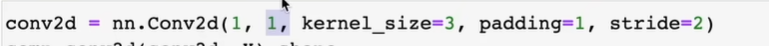